In [1]:
# import datasets
import csv
import torch
import torchtext
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
import sentencepiece as spm
import statistics as stats

import re
import string
import time
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device




import torchtext
from torchtext.datasets import IMDB
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')


In [2]:


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text



train_tokens = []
train_labels = []
for label, line in train_iter:
    clean_line = clean_text(line)
    train_labels.append(label-1)
    train_tokens.append(clean_line)

test_tokens = []
test_labels = []
for label, line in test_iter:
    clean_line = clean_text(line)
    test_labels.append(label-1)
    test_tokens.append(clean_line)


In [3]:
train = pd.DataFrame(train_tokens, columns = ['clean_text'])
test =  pd.DataFrame(test_tokens, columns = ['clean_text'])

In [4]:
train['target'] = train_labels
test['target'] = test_labels

In [5]:
print(train.head())


print(train['target'].unique())

                                          clean_text  target
0  i rented i am curiousyellow from my video stor...       0
1  i am curious yellow is a risible and pretentio...       0
2  if only to avoid making this type of film in t...       0
3  this film was probably inspired by godards mas...       0
4  oh brotherafter hearing about this ridiculous ...       0
[0 1]


In [6]:
with open('/Users/dhondupdolma/Desktop/preprocessed_data/train.text', 'w') as f:
    for text in train_tokens:
        f.write(f'{text.strip()}\n')
VOCAB_SIZE = 8000
# learn a BPE tokenization model

spm.SentencePieceTrainer.train(input='/Users/dhondupdolma/Desktop/preprocessed_data/train.text', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/dhondupdolma/Desktop/preprocessed_data/train.text
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privac

In [7]:
print(train.head())

                                          clean_text  target
0  i rented i am curiousyellow from my video stor...       0
1  i am curious yellow is a risible and pretentio...       0
2  if only to avoid making this type of film in t...       0
3  this film was probably inspired by godards mas...       0
4  oh brotherafter hearing about this ridiculous ...       0


In [8]:
sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

def tokenize_into_str(text):
      return ' '.join(sp.encode(text, out_type=str))

    
def tokenize_into_idx(text):
      return ' '.join([str(tok) for tok in sp.encode(text)])
    

    
train['text_tokenized'] = train['clean_text'].apply(tokenize_into_str)
train['text_indices'] = train['clean_text'].apply(tokenize_into_idx)
train['text_indices'].replace('', np.nan, inplace=True)
train.dropna(subset=['text_indices'], inplace=True)


In [9]:
test['text_tokenized'] = test['clean_text'].apply(tokenize_into_str)
test['text_indices'] = test['clean_text'].apply(tokenize_into_idx)
test['text_indices'].replace('', np.nan, inplace=True)
test.dropna(subset=['text_indices'], inplace=True)
test.head()

,clean_text,target,text_tokenized,text_indices
0,i love scifi and am willing to put up with a l...,0,▁i ▁love ▁scifi ▁and ▁am ▁willing ▁to ▁put ▁up...,6 418 2507 30 260 3706 32 758 240 94 4 536 250...
1,worth the entertainment value of a rental espe...,0,▁worth ▁the ▁entertainment ▁value ▁of ▁a ▁rent...,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...
2,its a totally average film with a few semialri...,0,▁its ▁a ▁totally ▁average ▁film ▁with ▁a ▁few ...,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...
3,star rating saturday night friday night fri...,0,▁star ▁rating ▁saturday ▁night ▁friday ▁night ...,787 1707 4819 813 5125 813 5125 4236 5471 813 ...
4,first off let me say if you havent enjoyed a v...,0,▁first ▁off ▁let ▁me ▁say ▁if ▁you ▁havent ▁en...,352 374 767 190 445 214 95 2020 1467 4 2043 17...


In [10]:
def count_tokens(text_indices):
    tokens = text_indices.split(' ')
    return len(tokens)

train['sequence_length'] = train['text_indices'].apply(count_tokens)
test['sequence_length'] = test['text_indices'].apply(count_tokens)


In [11]:
print(f"Train:\tmean={stats.mean(train['sequence_length']):.2f}\tstd={stats.stdev(train['sequence_length']):.2f}")
print(f"Test:\tmean={stats.mean(test['sequence_length']):.2f}\tstd={stats.stdev(test['sequence_length']):.2f}")



Train:	mean=268.81	std=207.25
Test:	mean=263.51	std=202.07


In [12]:
X_train = train[[col for col in train.columns if not col == 'target']]
y_train = train['target']

X_valid = test[[col for col in test.columns if not col == 'target']]
y_valid = test['target']

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)

# save them
train_data.to_pickle('/Users/dhondupdolma/Desktop/preprocessed_data/train.pkl')
valid_data.to_pickle('/Users/dhondupdolma/Desktop/preprocessed_data/valid.pkl')
test.to_pickle('/Users/dhondupdolma/Desktop/preprocessed_data/test.pkl')


In [13]:

class IMDB(Dataset):
    def __init__(self, pickle_path):
        self.dataset = pd.read_pickle(pickle_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text_indices_string = self.dataset['text_indices'].iloc[idx]
        text_indices = [int(tok_idx) for tok_idx in text_indices_string.split(' ')]
        sequence_length = int(self.dataset['sequence_length'].iloc[idx])
        label = None
        if 'target' in self.dataset.columns:
            label = int(self.dataset['target'].iloc[idx])
        return text_indices, sequence_length, label


    


In [14]:
train_dataset = IMDB('/Users/dhondupdolma/Desktop/preprocessed_data/train.pkl')
valid_dataset = IMDB('/Users/dhondupdolma/Desktop/preprocessed_data/valid.pkl')
print(train_dataset[0])
print(valid_dataset[0])

([6, 3518, 6, 260, 4297, 4458, 789, 177, 222, 1251, 2756, 353, 33, 145, 7, 5294, 7990, 64, 6735, 46, 239, 46, 78, 352, 1807, 40, 6, 357, 1631, 64, 120, 352, 46, 78, 92, 1356, 163, 335, 5455, 5899, 214, 46, 454, 2183, 32, 4024, 62, 1713, 3757, 436, 4, 929, 33, 382, 2931, 6558, 6, 263, 268, 32, 238, 62, 85, 1554, 423, 413, 42, 1334, 1590, 689, 4, 594, 7227, 1457, 3472, 2140, 36, 3964, 146, 1484, 32, 1570, 966, 250, 246, 198, 458, 40, 2261, 250, 1484, 32, 1834, 169, 509, 66, 487, 32, 853, 173, 1223, 33, 1819, 63, 217, 7, 2226, 5535, 7974, 649, 198, 1000, 2594, 3113, 529, 82, 7, 5612, 648, 30, 3643, 3113, 40, 7, 5179, 3754, 40, 730, 4889, 7225, 1787, 30, 4348, 1987, 443, 422, 33, 3722, 3430, 7986, 198, 277, 1664, 487, 63, 5167, 250, 204, 729, 94, 169, 1457, 3887, 726, 5620, 30, 2539, 1042, 1310, 2673, 190, 198, 6, 260, 4297, 4458, 789, 42, 64, 573, 1709, 62, 78, 2931, 3010, 6762, 263, 7, 729, 30, 2510, 517, 117, 608, 30, 667, 730, 256, 388, 151, 109, 788, 172, 173, 1676, 60, 369, 6351, 907

In [15]:
def generate_batch(batch):
    batch_indices = []
    batch_labels = []
    offsets = [0]

    for text_indices, sequence_length, label in batch:
        batch_indices.extend(text_indices)
        batch_labels.append(label)
        offsets.append(sequence_length)

    batch_indices = torch.tensor(batch_indices, dtype=torch.long)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return batch_indices, offsets, batch_labels


BATCH_SIZE = 8
EMBED_DIM = 32
NUM_CLASS = 2




In [16]:
# two-layer MLP

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size , embed_dim , sparse=True)
        num_layer = 100 #200
        self.fc1 = nn.Linear(embed_dim , num_layer) 
        self.fc2 = nn.Linear(num_layer , num_class)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()


    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc2(self.fc1(embedded))

model = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() #clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        #forward pass
        output = model(text, offsets)
        #get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        #calculate gradients
        loss.backward()
        #update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size

N_EPOCHS = 100
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')


	Train Loss: 0.073 | Train Acc: 68.55%
	 Val. Acc: 73.35%
	Train Loss: 0.052 | Train Acc: 81.66%
	 Val. Acc: 80.88%
	Train Loss: 0.044 | Train Acc: 85.24%
	 Val. Acc: 82.54%
	Train Loss: 0.039 | Train Acc: 87.12%
	 Val. Acc: 71.70%
	Train Loss: 0.036 | Train Acc: 88.42%
	 Val. Acc: 87.06%
	Train Loss: 0.033 | Train Acc: 89.51%
	 Val. Acc: 86.80%
	Train Loss: 0.031 | Train Acc: 90.00%
	 Val. Acc: 86.44%
	Train Loss: 0.029 | Train Acc: 90.77%
	 Val. Acc: 77.12%
	Train Loss: 0.028 | Train Acc: 91.04%
	 Val. Acc: 85.64%
	Train Loss: 0.026 | Train Acc: 91.63%
	 Val. Acc: 87.31%
	Train Loss: 0.026 | Train Acc: 91.85%
	 Val. Acc: 86.84%
	Train Loss: 0.024 | Train Acc: 92.45%
	 Val. Acc: 84.20%
	Train Loss: 0.023 | Train Acc: 92.64%
	 Val. Acc: 83.94%
	Train Loss: 0.023 | Train Acc: 93.05%
	 Val. Acc: 86.85%
	Train Loss: 0.022 | Train Acc: 93.27%
	 Val. Acc: 86.82%
	Train Loss: 0.021 | Train Acc: 93.55%
	 Val. Acc: 86.74%
	Train Loss: 0.021 | Train Acc: 93.71%
	 Val. Acc: 85.94%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

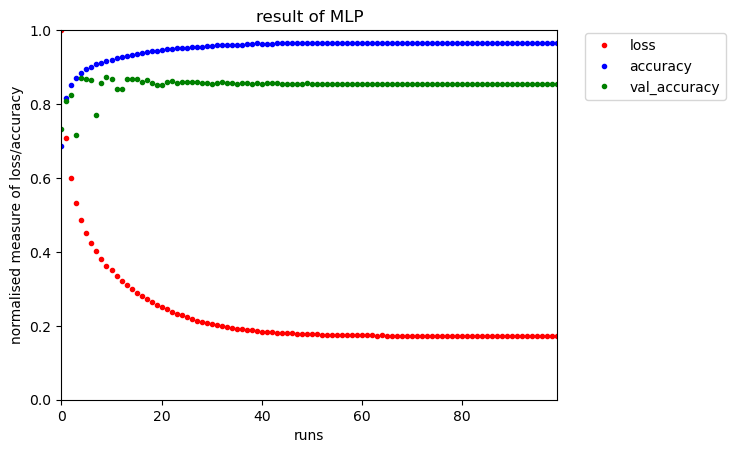

In [17]:
#two-layer plot

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [21]:
#single layer MLP

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size , embed_dim , sparse=True)
        num_layer = 100 #200
        self.fc1 = nn.Linear(embed_dim , num_layer) 
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()



    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc1(embedded)

model = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)


def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() #clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        #forward pass
        output = model(text, offsets)
        #get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        #calculate gradients
        loss.backward()
        #update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size



N_EPOCHS = 100
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')
# best val. acc for 100 layer Train Loss: 0.028 | Train Acc: 91.29% | Val. Acc: 87.54%
# best val. acc for 200 layer Train Loss: 0.031 | Train Acc: 90.15% | Val. Acc: 87.44% 


	Train Loss: 0.069 | Train Acc: 71.15%
	 Val. Acc: 82.38%
	Train Loss: 0.047 | Train Acc: 83.64%
	 Val. Acc: 85.56%
	Train Loss: 0.040 | Train Acc: 86.86%
	 Val. Acc: 83.26%
	Train Loss: 0.036 | Train Acc: 88.37%
	 Val. Acc: 81.09%
	Train Loss: 0.033 | Train Acc: 89.52%
	 Val. Acc: 85.14%
	Train Loss: 0.031 | Train Acc: 89.96%
	 Val. Acc: 84.46%
	Train Loss: 0.029 | Train Acc: 90.84%
	 Val. Acc: 86.46%
	Train Loss: 0.028 | Train Acc: 91.29%
	 Val. Acc: 87.54%
	Train Loss: 0.027 | Train Acc: 91.71%
	 Val. Acc: 86.78%
	Train Loss: 0.025 | Train Acc: 92.21%
	 Val. Acc: 87.14%
	Train Loss: 0.024 | Train Acc: 92.46%
	 Val. Acc: 86.01%
	Train Loss: 0.024 | Train Acc: 92.62%
	 Val. Acc: 86.98%
	Train Loss: 0.023 | Train Acc: 93.12%
	 Val. Acc: 87.08%
	Train Loss: 0.022 | Train Acc: 93.29%
	 Val. Acc: 87.14%
	Train Loss: 0.022 | Train Acc: 93.48%
	 Val. Acc: 86.92%
	Train Loss: 0.021 | Train Acc: 93.62%
	 Val. Acc: 86.32%
	Train Loss: 0.021 | Train Acc: 93.97%
	 Val. Acc: 86.92%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

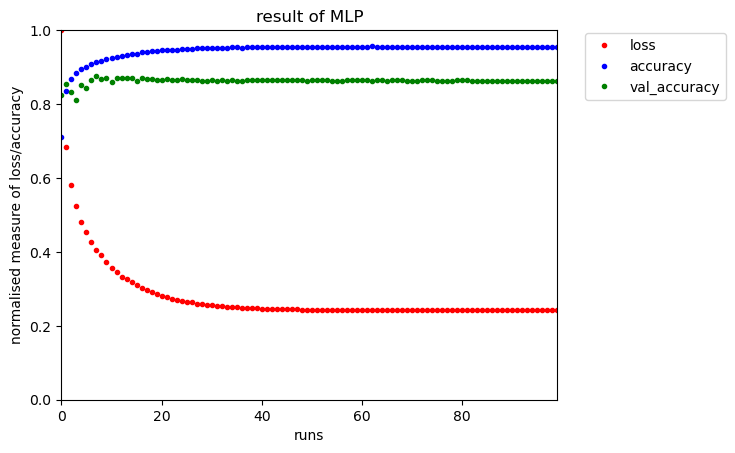

In [22]:

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show


